<h1 class="text-success text-center"> Fraud Detection - Data Exploration/Cleaning</h1>
The data was recoverred from a Kaggle competition: [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud)

<h2> Packages used in this Notebook</h2>

* Pandas:
* Numpy:
* Pickle:
* Matplotlib:
* Tensorflow:
* Keras:
* Scikit-learn:
* Seaborn: For statistical representations

In [36]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score

from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint
from keras import regularizers

%matplotlib inline

# Setting seaborn configuration for the figures
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

random_seed = 42
labels = ['Normal','Fraud']

<h2>Data Description</h2>
Data recorder during 2 days in September 2013

Dataset <b>highly unbalanced</b>: 492 frauds out of 284807 transactions (0.172% of transactions).

The dataset contains 28 variables which are the result of a PCA transformation. No prior knowledge about the original features (due to confidentiality).

Input variables:
* <b>Features V1,...,V28:</b> Principal components from the PCA transformation.
* <b>Time:</b> Seconds elapsed between each transactions since the first transaction.
* <b>Amount:</b> Transaction amount.
* <b>Class:</b>1 if is a fraud, 0 otherwise.

<b>Recommended metric:</b> Area Under the Precision-Recall Curve (AUPRC)

<h2>Data Exploration</h2>
To access the data, please use the following packages:

* s3fs (boto3 installed by default)

This package allows us to access the data in S3 (axiods directory).

In [2]:
#data = pd.read_csv("s3://axiods/detection_de_fraude/creditcard.csv")
data = pd.read_csv("data/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,...,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
# To check if there is any missing value in the dataframe
data.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
# Analysing the 'TIME' feature of the dataset
print("Fraud transactions:")
print(data.Time[data.Class==1].describe())
print("Normal transactions:")
print(data.Time[data.Class==0].describe())

Fraud transactions:
count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64
Normal transactions:
count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


Text(0,0.5,'Nb transactions')

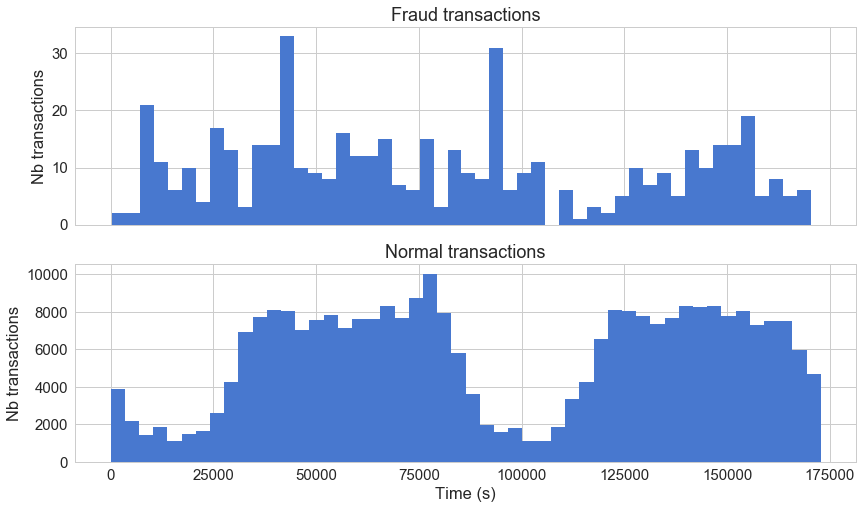

In [12]:
nb_bins = 50
f, ax = plt.subplots(2,1,sharex=True)
ax[0].hist(data.Time[data.Class==1],bins=nb_bins)
ax[0].set_title("Fraud transactions")
ax[0].set_ylabel("Nb transactions")

ax[1].hist(data.Time[data.Class==0],bins=nb_bins)
ax[1].set_title("Normal transactions")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Nb transactions")

In [11]:
# Analysing the 'AMOUNT' feature of the dataset
print("Fraud transactions:")
print(data.Amount[data.Class==1].describe())
print("Normal transactions:")
print(data.Amount[data.Class==0].describe())

Fraud transactions:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
Normal transactions:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


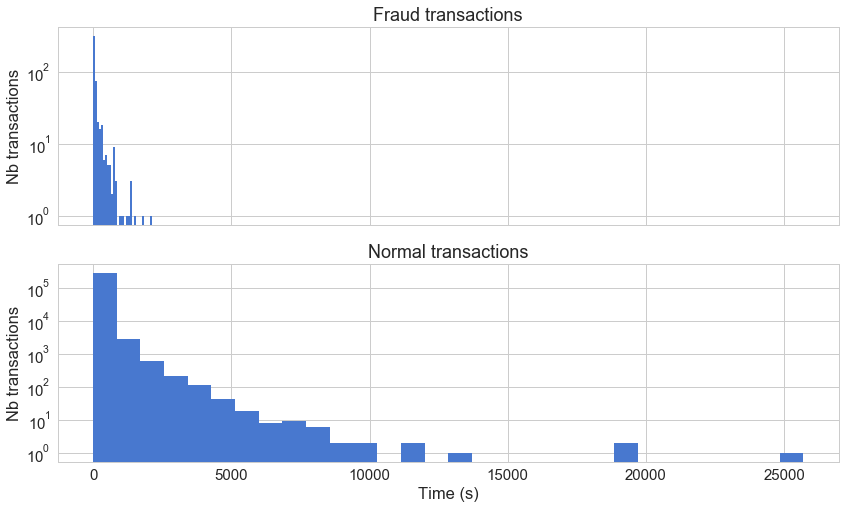

In [13]:
nb_bins = 30
f, ax = plt.subplots(2,1,sharex=True)
ax[0].hist(data.Amount[data.Class==1],bins=nb_bins)
ax[0].set_title("Fraud transactions")
ax[0].set_ylabel("Nb transactions")
ax[0].set_yscale('log')

ax[1].hist(data.Amount[data.Class==0],bins=nb_bins)
ax[1].set_title("Normal transactions")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Nb transactions")
ax[1].set_yscale('log') # Only for visualization purposes

<b>Analysing the relationship between TIME and AMOUNT</b>

Text(0.5,0,'Time (in seconds)')

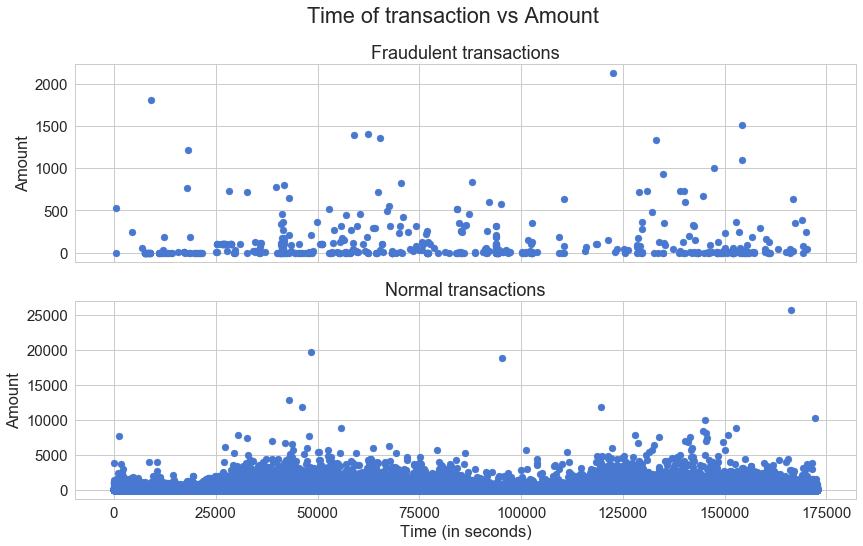

In [17]:
f, ax = plt.subplots(2,1,sharex=True)
f.suptitle('Time of transaction vs Amount')

ax[0].scatter(data.Time[data.Class==1],data.Amount[data.Class==1])
ax[0].set_title('Fraudulent transactions')
ax[0].set_ylabel('Amount')

ax[1].scatter(data.Time[data.Class==0],data.Amount[data.Class==0])
ax[1].set_title('Normal transactions')
ax[1].set_ylabel('Amount')
ax[1].set_xlabel('Time (in seconds)')

There is <b>NO VISUAL RELATIONSHIP/PATTERN</b> between the amount and the time in the dataset.

<h2>Implementing an Undercomplete Autoencoder</h2>

An [autoencoder](https://www.youtube.com/watch?v=FzS3tMl4Nsc&index=44&list=PL6Xpj9I5qXYEcOhn7TqghAJ6NAPrNmUBH) is a Neural Network for <b>Unsupervised Learning</b>. The advantage of unsupervised learning is to:

* Automatically extract meaningful features from the data.
* Leverage the availability of unlabeled data.
* Add a data-dependent regularizer to trainings.

Common <b>Loss function</b> to minimize: Squared Error

<b>NOTE:</b> Other neural networks used in Unsupervised Learning are: <b>Restricted Boltzmann Machines</b> and <b>Sparse Coding Models</b>.

<b>Preparing the data:</b>
* Dropping the 'Time' column from the dataset
* Standardize features by removing the mean and scaling to unit variance
* Dividing the dataset in X and Y groups. X has all the features except Class, and Y has only the Class column.

In [4]:
# Dropping 'Time'
X = data.drop(['Time','Class'],axis=1)
Y = data.Class

# Standardising features
X = StandardScaler().fit_transform(X)
#X = np.array(X)

#Y = np.array(Y).reshape((len(Y),1))

print("X shape:",np.shape(X))
print("Y shape:",np.shape(Y))

X shape: (284807, 29)
Y shape: (284807,)


In [5]:
X_train_tmp, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)
X_train = X_train_tmp[Y_train==0]
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.sum(Y_train))

(227442, 29)
(227845,)
403


<h2>Building the model</h2>
Using a MLP network with 4 full connected layers: 2 for the encoder and 2 for the decoder, plus a L1 regularization.

In [55]:
input_dim = X_train.shape[1]
encoder_l1 = int(input_dim/2)
encoder_l2 = int(encoder_l1/2)

decoder_l1 = encoder_l2
decoder_l2 = input_dim

<b>NOTE:</b> The order of the activation functions in the decoder are not the same as in the encoder.

In [7]:
def get_autoencoder_model():
    # Building the model
    inputs = Input(shape=(input_dim,))

    # ENCODER layers
    encoder = Dense(units=encoder_l1, activation="tanh",
                    activity_regularizer=regularizers.l1(10e-5))(inputs)
    encoder = Dense(units=encoder_l2, activation="relu")(encoder)

    # DECODER layers
    decoder = Dense(units=decoder_l1, activation="tanh")(encoder)
    decoder = Dense(units=decoder_l2, activation="relu")(decoder)

    # Defining the AUTOENCODER
    autoencoder = Model(inputs=inputs, output=decoder)

    # Compiling the model
    autoencoder.compile(optimizer='Adam',loss='mean_squared_error',
                       metrics=['accuracy'])
    
    return autoencoder

def get_variatonal_autoencoder_model():
    
    return autoencoder

In [19]:
# TRAINING process
nb_epochs = 500
batch_size = 2048

autoencoder = get_autoencoder_model()

# Defining checkpoints
bestModelFile = 'autoencoder.h5'
checkpoint = ModelCheckpoint(filepath=bestModelFile,verbose=1,
                             monitor='val_loss',mode='min',
                             save_best_only=True)

history = autoencoder.fit(X_train,X_train,epochs=nb_epochs,
                          batch_size=batch_size,shuffle=True,
                          validation_data=(X_test,X_test),verbose=1,
                          callbacks=[checkpoint])

/Users/jeancupe/ddf_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


Train on 227442 samples, validate on 56962 samples
Epoch 1/500
212992/227442 [===========================>..] - ETA: 0s - loss: 2.2335 - acc: 0.0686
Epoch 00001: val_loss improved from inf to 1.96106, saving model to autoencoder.h5
227442/227442 [==============================] - 1s 5us/step - loss: 2.2154 - acc: 0.0711 - val_loss: 1.9611 - val_acc: 0.1102
Epoch 2/500
225280/227442 [============================>.] - ETA: 0s - loss: 1.5364 - acc: 0.1295
Epoch 00002: val_loss improved from 1.96106 to 1.26907, saving model to autoencoder.h5
227442/227442 [==============================] - 1s 2us/step - loss: 1.5332 - acc: 0.1296 - val_loss: 1.2691 - val_acc: 0.1516
Epoch 3/500
200704/227442 [=========================>....] - ETA: 0s - loss: 1.0631 - acc: 0.1033
Epoch 00003: val_loss improved from 1.26907 to 1.05607, saving model to autoencoder.h5
227442/227442 [==============================] - 0s 2us/step - loss: 1.0515 - acc: 0.0998 - val_loss: 1.0561 - val_acc: 0.0707
Epoch 4/500
22118

208896/227442 [==========================>...] - ETA: 0s - loss: 0.8121 - acc: 0.2664
Epoch 00027: val_loss improved from 0.88516 to 0.88444, saving model to autoencoder.h5
227442/227442 [==============================] - 1s 2us/step - loss: 0.8112 - acc: 0.2664 - val_loss: 0.8844 - val_acc: 0.2648
Epoch 28/500
217088/227442 [===========================>..] - ETA: 0s - loss: 0.8109 - acc: 0.2670
Epoch 00028: val_loss improved from 0.88444 to 0.88269, saving model to autoencoder.h5
227442/227442 [==============================] - 1s 2us/step - loss: 0.8102 - acc: 0.2668 - val_loss: 0.8827 - val_acc: 0.2685
Epoch 29/500
227328/227442 [============================>.] - ETA: 0s - loss: 0.8091 - acc: 0.2672
Epoch 00029: val_loss did not improve
227442/227442 [==============================] - 0s 2us/step - loss: 0.8092 - acc: 0.2672 - val_loss: 0.8838 - val_acc: 0.2678
Epoch 30/500
227328/227442 [============================>.] - ETA: 0s - loss: 0.8092 - acc: 0.2666
Epoch 00030: val_loss im

Epoch 55/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7978 - acc: 0.3244
Epoch 00055: val_loss improved from 0.86761 to 0.86742, saving model to autoencoder.h5
227442/227442 [==============================] - 1s 2us/step - loss: 0.7978 - acc: 0.3245 - val_loss: 0.8674 - val_acc: 0.3293
Epoch 56/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7959 - acc: 0.3310
Epoch 00056: val_loss did not improve
227442/227442 [==============================] - 0s 2us/step - loss: 0.7958 - acc: 0.3318 - val_loss: 0.8700 - val_acc: 0.3284
Epoch 57/500
219136/227442 [===========================>..] - ETA: 0s - loss: 0.7931 - acc: 0.3361
Epoch 00057: val_loss improved from 0.86742 to 0.86065, saving model to autoencoder.h5
227442/227442 [==============================] - 1s 2us/step - loss: 0.7945 - acc: 0.3362 - val_loss: 0.8607 - val_acc: 0.3428
Epoch 58/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7910 - acc: 0.3377
Epoch 00058

Epoch 84/500
200704/227442 [=========================>....] - ETA: 0s - loss: 0.7711 - acc: 0.3575
Epoch 00084: val_loss improved from 0.83937 to 0.83936, saving model to autoencoder.h5
227442/227442 [==============================] - 0s 2us/step - loss: 0.7702 - acc: 0.3572 - val_loss: 0.8394 - val_acc: 0.3544
Epoch 85/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7713 - acc: 0.3561
Epoch 00085: val_loss did not improve
227442/227442 [==============================] - 0s 2us/step - loss: 0.7705 - acc: 0.3564 - val_loss: 0.8414 - val_acc: 0.3586
Epoch 86/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7701 - acc: 0.3564
Epoch 00086: val_loss did not improve
227442/227442 [==============================] - 0s 2us/step - loss: 0.7719 - acc: 0.3564 - val_loss: 0.8422 - val_acc: 0.3596
Epoch 87/500
219136/227442 [===========================>..] - ETA: 0s - loss: 0.7693 - acc: 0.3562
Epoch 00087: val_loss did not improve
227442/227442 [=======

206848/227442 [==========================>...] - ETA: 0s - loss: 0.7579 - acc: 0.3721
Epoch 00113: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7609 - acc: 0.3720 - val_loss: 0.8379 - val_acc: 0.3691
Epoch 114/500
225280/227442 [============================>.] - ETA: 0s - loss: 0.7635 - acc: 0.3717
Epoch 00114: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7629 - acc: 0.3717 - val_loss: 0.8287 - val_acc: 0.3808
Epoch 115/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7549 - acc: 0.3746
Epoch 00115: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7572 - acc: 0.3746 - val_loss: 0.8335 - val_acc: 0.3802
Epoch 116/500
202752/227442 [=========================>....] - ETA: 0s - loss: 0.7611 - acc: 0.3724
Epoch 00116: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7590 - acc

221184/227442 [============================>.] - ETA: 0s - loss: 0.7476 - acc: 0.3897
Epoch 00142: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7462 - acc: 0.3897 - val_loss: 0.8136 - val_acc: 0.3916
Epoch 143/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7450 - acc: 0.3900
Epoch 00143: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7467 - acc: 0.3900 - val_loss: 0.8250 - val_acc: 0.3843
Epoch 144/500
227328/227442 [============================>.] - ETA: 0s - loss: 0.7481 - acc: 0.3904
Epoch 00144: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7480 - acc: 0.3904 - val_loss: 0.8176 - val_acc: 0.3885
Epoch 145/500
208896/227442 [==========================>...] - ETA: 0s - loss: 0.7448 - acc: 0.3920
Epoch 00145: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7459 - acc

210944/227442 [==========================>...] - ETA: 0s - loss: 0.7335 - acc: 0.4326
Epoch 00171: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7328 - acc: 0.4325 - val_loss: 0.8008 - val_acc: 0.4366
Epoch 172/500
227328/227442 [============================>.] - ETA: 0s - loss: 0.7325 - acc: 0.4333
Epoch 00172: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7325 - acc: 0.4333 - val_loss: 0.8074 - val_acc: 0.4312
Epoch 173/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7326 - acc: 0.4329
Epoch 00173: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7324 - acc: 0.4330 - val_loss: 0.8024 - val_acc: 0.4304
Epoch 174/500
221184/227442 [============================>.] - ETA: 0s - loss: 0.7303 - acc: 0.4333
Epoch 00174: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7310 - acc

Epoch 201/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7261 - acc: 0.4345
Epoch 00201: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7257 - acc: 0.4347 - val_loss: 0.8023 - val_acc: 0.4362
Epoch 202/500
219136/227442 [===========================>..] - ETA: 0s - loss: 0.7277 - acc: 0.4339
Epoch 00202: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7274 - acc: 0.4339 - val_loss: 0.7952 - val_acc: 0.4343
Epoch 203/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7240 - acc: 0.4345
Epoch 00203: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7251 - acc: 0.4348 - val_loss: 0.7998 - val_acc: 0.4181
Epoch 204/500
217088/227442 [===========================>..] - ETA: 0s - loss: 0.7264 - acc: 0.4335
Epoch 00204: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss

Epoch 232/500
208896/227442 [==========================>...] - ETA: 0s - loss: 0.7249 - acc: 0.4326
Epoch 00232: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7235 - acc: 0.4319 - val_loss: 0.8016 - val_acc: 0.4212
Epoch 233/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7274 - acc: 0.4291
Epoch 00233: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7275 - acc: 0.4292 - val_loss: 0.7941 - val_acc: 0.4369
Epoch 234/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7228 - acc: 0.4314
Epoch 00234: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7231 - acc: 0.4319 - val_loss: 0.7940 - val_acc: 0.4261
Epoch 235/500
212992/227442 [===========================>..] - ETA: 0s - loss: 0.7229 - acc: 0.4315
Epoch 00235: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss

Epoch 263/500
225280/227442 [============================>.] - ETA: 0s - loss: 0.7233 - acc: 0.4293
Epoch 00263: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7227 - acc: 0.4292 - val_loss: 0.7924 - val_acc: 0.4351
Epoch 264/500
225280/227442 [============================>.] - ETA: 0s - loss: 0.7211 - acc: 0.4291
Epoch 00264: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7218 - acc: 0.4292 - val_loss: 0.7940 - val_acc: 0.4313
Epoch 265/500
219136/227442 [===========================>..] - ETA: 0s - loss: 0.7236 - acc: 0.4287
Epoch 00265: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7228 - acc: 0.4285 - val_loss: 0.7946 - val_acc: 0.4324
Epoch 266/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7219 - acc: 0.4290
Epoch 00266: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss

Epoch 294/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7227 - acc: 0.4281
Epoch 00294: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7219 - acc: 0.4284 - val_loss: 0.7908 - val_acc: 0.4252
Epoch 295/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7214 - acc: 0.4279
Epoch 00295: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7215 - acc: 0.4279 - val_loss: 0.7922 - val_acc: 0.4357
Epoch 296/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7209 - acc: 0.4285
Epoch 00296: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7216 - acc: 0.4287 - val_loss: 0.7950 - val_acc: 0.4209
Epoch 297/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7241 - acc: 0.4270
Epoch 00297: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss

Epoch 325/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7218 - acc: 0.4284
Epoch 00325: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7214 - acc: 0.4285 - val_loss: 0.7954 - val_acc: 0.4275
Epoch 326/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7218 - acc: 0.4274
Epoch 00326: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7215 - acc: 0.4276 - val_loss: 0.8013 - val_acc: 0.4251
Epoch 327/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7275 - acc: 0.4240
Epoch 00327: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7274 - acc: 0.4240 - val_loss: 0.7912 - val_acc: 0.4312
Epoch 328/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7213 - acc: 0.4290
Epoch 00328: val_loss improved from 0.79046 to 0.79030, saving model to autoencoder.h5
227442/227442 [===

223232/227442 [============================>.] - ETA: 0s - loss: 0.7216 - acc: 0.4281
Epoch 00355: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7211 - acc: 0.4281 - val_loss: 0.7936 - val_acc: 0.4227
Epoch 356/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7217 - acc: 0.4278
Epoch 00356: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7221 - acc: 0.4275 - val_loss: 0.7919 - val_acc: 0.4295
Epoch 357/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7199 - acc: 0.4274
Epoch 00357: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7212 - acc: 0.4277 - val_loss: 0.7900 - val_acc: 0.4261
Epoch 358/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7215 - acc: 0.4281
Epoch 00358: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7209 - acc

Epoch 386/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7210 - acc: 0.4276
Epoch 00386: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7216 - acc: 0.4276 - val_loss: 0.7941 - val_acc: 0.4221
Epoch 387/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7213 - acc: 0.4278
Epoch 00387: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7212 - acc: 0.4277 - val_loss: 0.7951 - val_acc: 0.4224
Epoch 388/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7217 - acc: 0.4282
Epoch 00388: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7211 - acc: 0.4282 - val_loss: 0.7904 - val_acc: 0.4276
Epoch 389/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7221 - acc: 0.4277
Epoch 00389: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss

Epoch 417/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7216 - acc: 0.4279
Epoch 00417: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7208 - acc: 0.4281 - val_loss: 0.7924 - val_acc: 0.4300
Epoch 418/500
223232/227442 [============================>.] - ETA: 0s - loss: 0.7208 - acc: 0.4273
Epoch 00418: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7211 - acc: 0.4272 - val_loss: 0.7913 - val_acc: 0.4216
Epoch 419/500
219136/227442 [===========================>..] - ETA: 0s - loss: 0.7220 - acc: 0.4273
Epoch 00419: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7215 - acc: 0.4273 - val_loss: 0.7922 - val_acc: 0.4238
Epoch 420/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7202 - acc: 0.4280
Epoch 00420: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss

Epoch 448/500
215040/227442 [===========================>..] - ETA: 0s - loss: 0.7213 - acc: 0.4274
Epoch 00448: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7210 - acc: 0.4270 - val_loss: 0.7905 - val_acc: 0.4295
Epoch 449/500
227328/227442 [============================>.] - ETA: 0s - loss: 0.7216 - acc: 0.4262
Epoch 00449: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7215 - acc: 0.4262 - val_loss: 0.7942 - val_acc: 0.4244
Epoch 450/500
227328/227442 [============================>.] - ETA: 0s - loss: 0.7211 - acc: 0.4269
Epoch 00450: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss: 0.7210 - acc: 0.4269 - val_loss: 0.7907 - val_acc: 0.4284
Epoch 451/500
208896/227442 [==========================>...] - ETA: 0s - loss: 0.7200 - acc: 0.4275
Epoch 00451: val_loss did not improve
227442/227442 [==============================] - 1s 3us/step - loss

Epoch 479/500
204800/227442 [==========================>...] - ETA: 0s - loss: 0.7208 - acc: 0.4281
Epoch 00479: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7210 - acc: 0.4275 - val_loss: 0.8256 - val_acc: 0.4056
Epoch 480/500
225280/227442 [============================>.] - ETA: 0s - loss: 0.7466 - acc: 0.4142
Epoch 00480: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7455 - acc: 0.4143 - val_loss: 0.7907 - val_acc: 0.4286
Epoch 481/500
221184/227442 [============================>.] - ETA: 0s - loss: 0.7198 - acc: 0.4284
Epoch 00481: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss: 0.7199 - acc: 0.4284 - val_loss: 0.7922 - val_acc: 0.4259
Epoch 482/500
204800/227442 [==========================>...] - ETA: 0s - loss: 0.7207 - acc: 0.4276
Epoch 00482: val_loss did not improve
227442/227442 [==============================] - 1s 2us/step - loss

Working with the best model only:

In [20]:
autoencoder = load_model(bestModelFile)

<b>Plotting the history of metrics:</b>

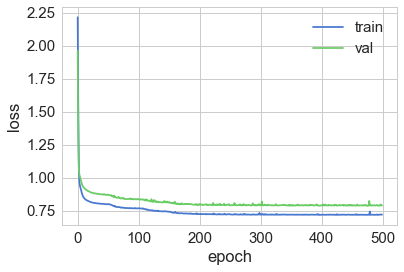

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'],loc='upper right')

<b>Reconstruction error:</b>
We can compare the reconstructon error for normal transactions and fraudulent transactions.

Nb samples in test: 227442
266.13973205995615


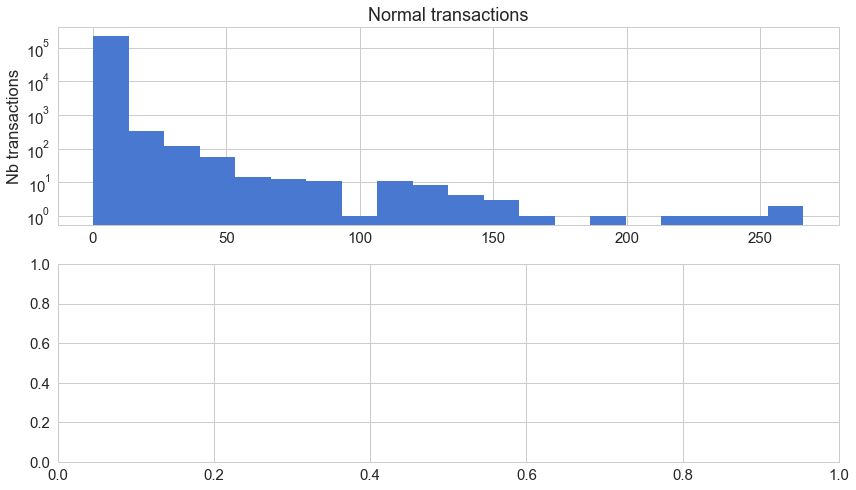

In [54]:
X_pred = autoencoder.predict(X_train)

mse = np.mean(np.power(X_train - X_pred, 2), axis =1)

f, ax = plt.subplots(2,1)
#ax[0].hist(mse[(Y_test==0) & (mse<10)],bins=20)
ax[0].hist(mse,bins=20)
#ax[0].hist(mse[(Y_test==0)],bins=20)
ax[0].set_yscale('log')
ax[0].set_ylabel('Nb transactions')
ax[0].set_title('Normal transactions')
'''ax[1].hist(mse[Y_test==1],bins=20)
ax[1].set_ylabel('Nb transactions')
ax[1].set_title('Fraud transactions')
ax[1].set_xlabel('Mean Squared Error (MSE)')
'''
print("Nb samples in test:",len(mse))
#print("Nb samples with error MSE less than 10:",np.shape(mse[(Y_test==0) & (mse<10)]))
#print("Nb samples of Fraud transactions:",np.sum(Y_test))
print(np.max(mse))

In [48]:
# Setting the threshold from the last figure
threshold = 4.5
Y_pred = [1 if e > threshold else 0 for e in mse]
print(confusion_matrix(Y_test,Y_pred))
print(f1_score(Y_test,Y_pred))

[[56271   602]
 [   17    72]]
0.18872870249017037
